# AI Essay Generation

Investigation into the data provided as part of the [Kaggle Competition to detect AI generated essays](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/overview). The given training dataset consists predominantly of student-written essays, with only a few LLM generated examples.

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import (
    GPT2LMHeadModel, 
    GPT2TokenizerFast, 
    pipeline,
    AutoModelForSeq2SeqLM, 
    AutoTokenizer
)

from pathlib import Path
from os import getenv

In [54]:
def process_prompt(prompt):
    """
    Get prompt in a form that is easy to rewrite for
    instructions
    """
    from string import digits
    
    question = prompt["instructions"].split(".")[0]

    sources = dict()
    title = None
    for line in prompt["source_text"].split("\n\n"):
        if line.startswith("# "):
            title = line.lstrip("# ")
            sources[title] = []
            continue
        assert title, f"title is not known for line {line.strip()}"
        sources[title].append(line.lstrip(digits).lstrip("# ").rstrip())
    return question, sources


def generate_instructions(prompt, num_pars=2):
    """
    Generate some instructions, subsampling the number
    of paragraphs from each source to fit better into 
    token limits
    """
    question, sources = process_prompt(prompt)

    def sample_sources(sources, num_pars):
        sampled = []
        for s, ps in sources.items():
            i = np.random.choice(len(ps) - num_pars)
            sampled.append(f"SOURCE: {s}")
            sampled.extend(ps[i:i+num_pars])
        return "\n\n".join(sampled)

    llm_prompt = f"""
    Based on the following sources:

    {sample_sources(sources, num_pars)}

    {question}, using information from the sources.

    ESSAY: Limiting car usage may sound like a controversial idea. After all,
    """
    return llm_prompt

In [10]:
data_dir = Path(getenv("HOME"), "data", "llm-data", "ai-generated-essays")
prompts_fp = Path(data_dir, "train_prompts.csv")
assert prompts_fp.exists()
prompts = pd.read_csv(prompts_fp).set_index("prompt_id").to_dict(orient="index")
# Prompts: prompt_name, instructions, source_text

In [83]:
prompts[0]["instructions"]

'Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.'

In [38]:
for _, p in prompts.items():
    print(len(p["source_text"].split()))

2180
2046


In [13]:
essays_fp = Path(data_dir, "train_essays.csv")
assert essays_fp.exists()
essays = pd.read_csv(essays_fp)

In [21]:
essays.head(1)

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0


In [23]:
print(essays.query("generated == 0").sample(1).text.iloc[0])

Dear State Senator, After experiencing the dispute over the outcome of an Electoral College vote in 2000 I realized that the Electoral College is an old fashioned and unfair voting system for our next presidents. The vote of all United States citizens should be taken account but with each state only getting a single vote it is highly unethical for a state with 500,000 voters like Wyoming and a state with 35 million voters like California having the same amount of votes.

The candidates who of course want to win will want to spend there time campaigning in states they think they have a chance of winning over but what about states that they do not think will vote for them? States like South Carolina and Rhode Island during the 2000 campaign didn't even see the candidates at all. This all because of the winner take all system established in the Electoral College.

There are people who still support the electoral college but on what end? They say it has a more certainty of outcome but ther

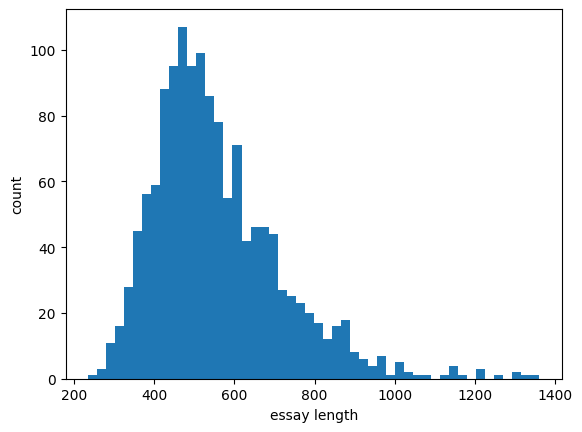

In [20]:
essay_lengths = essays.text.str.split().str.len()
plt.hist(essay_lengths, bins=50)
plt.xlabel("essay length")
plt.ylabel("count")
plt.show()

## Essay Generation

In [155]:
class EssayGenerator:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def generate_from_prompt(self, prompt, **kwargs):
        prompt_tokens = self.tokenizer(prompt, return_tensors="pt")
        completion = self.model.generate(
            **prompt_tokens, 
            do_sample=True,
            **kwargs
        )
        return self.tokenizer.decode(
            completion[0],
            skip_special_tokens=True,
        )


class InstructionGenerator:
    @classmethod
    def generate_with_human_intro(
        cls, prompt, examples, length=16
    ):
        intro = examples.sample(1).text.iloc[0]
        intro = " ".join(intro.split()[:length])
        return f"{prompt}\n\n{intro}"

In [152]:
gpt_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt_tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

t5_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
t5_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

In [161]:
prompt = InstructionGenerator.generate_with_human_intro(
    prompts[0]["instructions"], essays.query("prompt_id == 0")
)

In [164]:
prompt

'Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.\n\nA life filled to the brim of better days is what we all want, and limiting'

In [166]:
genr = EssayGenerator(gpt_model, gpt_tokenizer)

In [171]:
%%time
print(genr.generate_from_prompt(
    prompt,
    max_new_tokens=500,
    temperature=0.8
))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.

A life filled to the brim of better days is what we all want, and limiting car use is the best way to do it.

In addition to driving to work, you can also spend some time with your children.

I can't tell you how much more important it is to you that you do so, because you, the reader, are responsible for putting together a life filled with good health, happiness, and education, and that your children are not just your children's children.

This post was written for the 2012 State 

In [176]:
t5_model.config.n_positions

512

In [178]:
hasattr(t5_model.config, "n_positions")

True